In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
#import joblib
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Flatten, Input, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
df = pd.read_csv('./eyes_data.csv')
df['cote'] = df['cote'].map({'gauche' : 0, 'droit' : 1})
df[df.columns[0:1024]] = df[df.columns[0:1024]]/255
df = df.drop('id',1)

df[df.columns[1024]] = df[df.columns[1024]]/640
df[df.columns[1025]] = df[df.columns[1025]]/480
df[df.columns[1027]] = df[df.columns[1027]]/640
df[df.columns[1028]] = df[df.columns[1028]]/480
df[df.columns[1030]] = df[df.columns[1030]]/2
df[df.columns[1031]] = df[df.columns[1031]]/1920
df[df.columns[1032]] = df[df.columns[1032]]/1080

#df['prediction_x']= df['prediction_x'].astype(str)
#df['prediction_y']= df['prediction_y'].astype(str)
#df['prediction'] = df[['prediction_x', 'prediction_y']].agg('-'.join, axis=1)
#df = df.drop('prediction_x',1)
#df = df.drop('prediction_y',1)
df

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_0_8,pixel_0_9,...,pixel_31_31,milieu_crop_x,milieu_crop_y,distance,milieu_oeil_x,milieu_oeil_y,taille_original,cote,prediction_x,prediction_y
0,0.294118,0.282353,0.258824,0.239216,0.219608,0.211765,0.219608,0.211765,0.211765,0.231373,...,0.639216,0.492188,0.418750,0.501,0.431250,0.383333,42,0.0,0.050000,0.050000
1,0.674510,0.666667,0.658824,0.600000,0.529412,0.482353,0.458824,0.427451,0.411765,0.403922,...,0.721569,0.492188,0.418750,0.501,0.546875,0.383333,36,0.5,0.050000,0.050000
2,0.490196,0.490196,0.443137,0.368627,0.329412,0.317647,0.301961,0.286275,0.258824,0.231373,...,0.658824,0.495312,0.422917,0.501,0.437500,0.370833,40,0.0,0.050000,0.150000
3,0.650980,0.603922,0.505882,0.439216,0.423529,0.407843,0.392157,0.372549,0.376471,0.380392,...,0.725490,0.495312,0.422917,0.501,0.543750,0.383333,38,0.5,0.050000,0.150000
4,0.458824,0.443137,0.372549,0.317647,0.305882,0.294118,0.266667,0.247059,0.215686,0.207843,...,0.627451,0.503125,0.425000,0.515,0.448437,0.379167,40,0.0,0.150000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.529412,0.560784,0.588235,0.611765,0.611765,0.600000,0.560784,0.525490,0.505882,0.501961,...,0.666667,0.495312,0.560417,0.462,0.553125,0.520833,40,0.5,0.063542,0.837037
1996,0.760784,0.733333,0.717647,0.733333,0.745098,0.745098,0.729412,0.701961,0.678431,0.647059,...,0.854902,0.479687,0.558333,0.469,0.410938,0.508333,48,0.0,0.761979,0.283333
1997,0.458824,0.490196,0.533333,0.560784,0.592157,0.611765,0.627451,0.627451,0.607843,0.584314,...,0.650980,0.479687,0.558333,0.469,0.535937,0.516667,43,0.5,0.761979,0.283333
1998,0.745098,0.756863,0.756863,0.737255,0.721569,0.705882,0.690196,0.662745,0.631373,0.603922,...,0.890196,0.454688,0.562500,0.467,0.392188,0.516667,46,0.0,0.953125,0.531481


In [3]:
y = df.iloc[0:2000, 1031:1033]
x = df.iloc[0:2000, 0:1031]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

X1_train = x_train[0:x_train.shape[0],0:1024]
X2_train = x_train[0:x_train.shape[0],1024:1031]

X1_val = x_val[0:x_val.shape[0],0:1024]
X2_val = x_val[0:x_val.shape[0],1024:1031]


X1_train = X1_train.reshape(1600,32,32)
X1_val = X1_val.reshape(400,32,32)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

print(X1_train.shape)
print(X2_train.shape)
print(X1_val.shape)
print(X2_val.shape)

#print(X1_train[0])
#print(X2_train[0])

#print(X1_val[0])
#print(X2_val[0])

(1600, 1031)
(400, 1031)
(1600, 2)
(400, 2)
(1600, 32, 32)
(1600, 7)
(400, 32, 32)
(400, 7)


In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='min')
mcp_save = ModelCheckpoint('checkpoint.hdf5', save_best_only=True, monitor='val_loss', mode='min',verbose=0)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50
                                   , verbose=1, mode='min', min_lr =0.000001)

# define two sets of inputs
inputA = Input(shape=(32,32,1))
inputB = Input(shape=(7,))
 
# the first branch operates on the first input
x = Conv2D(3,(3, 3), padding="same")(inputA)
x = Activation("relu")(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(3,(3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(3,(3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(3,(3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(3,(3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

out_x = Flatten()(x)
print(out_x.shape)

# the second branch opreates on the second input
y = Dense(7, activation="relu")(inputB)
y = Dense(5, activation="relu")(y)
y = Dense(5, activation="relu")(y)
y = Dense(7, activation="relu")(y)
out_y = Flatten()(y)
print(out_y.shape)

# combine the output of the two branches
combined = concatenate([out_x, out_y])
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(10, activation="swish")(combined)
z = Dense(8, activation="swish")(z)
z = Dense(6, activation="swish")(z)
z = Dense(4, activation="swish")(z)
z = Dense(2, activation="swish")(z)
 
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[inputA, inputB], outputs=z)
model.compile(loss=['mae'], optimizer='adam',metrics=['mse'])
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=2000,
                    verbose=1, callbacks=[earlyStopping,mcp_save,reduce_lr_loss]
                    , validation_data = ([X1_val,X2_val],y_val))

In [4]:
import time
#test predict and inference time. Use timeit for more precise inference time
df3 = df[df.columns[0:1024]]
df3 = df3.loc[4]
df3 = df3.to_numpy()
df3 = df3.reshape(1,32,32)
#df3 = np.expand_dims(df3, axis=-1)
print(df3.shape)

df4 = df[df.columns[1025:1032]]
df4 = df4.loc[2]
df4 = df4.to_numpy()
df4 = df4.reshape(1, -1)
print(df4.shape)

from tensorflow.keras.models import load_model

loaded_model = load_model('./my_eyes.h5', compile = False)
start = time.time()
a = 1000
for i in range(0,a):
    pred1 = loaded_model.predict_on_batch([df3,df4])
print(pred1)
end = time.time()
print(end-start)
print((end-start)/a)


(1, 32, 32)
(1, 7)
[[0.21822242 0.04614801]]
9.999264001846313
0.009999264001846314


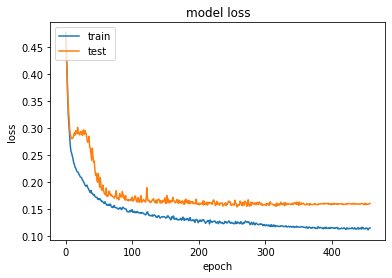

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

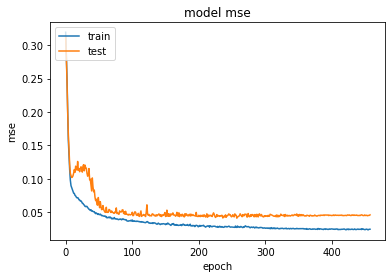

In [15]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('my_eyes.h5')

pixel_0_0      0.459033
pixel_0_1      0.452843
pixel_0_2      0.443490
pixel_0_3      0.432275
pixel_0_4      0.420069
                 ...   
pixel_31_27    0.740825
pixel_31_28    0.739314
pixel_31_29    0.736451
pixel_31_30    0.732620
pixel_31_31    0.727633
Length: 1024, dtype: float64
<class 'pandas.core.frame.DataFrame'>


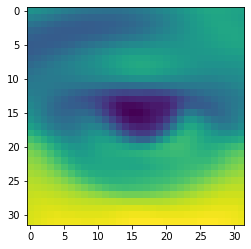

In [5]:
df2 = df[df.columns[0:1024]]
print(df2.mean())
print(type(df2))
df2 = df2.mean()
df2 = df2.to_numpy()
df2 = df2.reshape(32,32)
plt.imshow(df2)

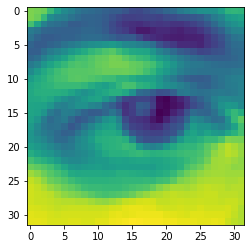

In [6]:
df3 = df[df.columns[0:1024]]
df3 = df3.loc[1]
df3 = df3.to_numpy()
df3 = df3.reshape(32,32)
plt.imshow(df3)

In [7]:
toplot = df.iloc[0:2000, 1029]
toplot2 = toplot.iloc[::2]
toplot1 = toplot[toplot.index % 2 != 0]

D:\Programmes\Anaconda\envs\My-project\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='taille_original', ylabel='count'>

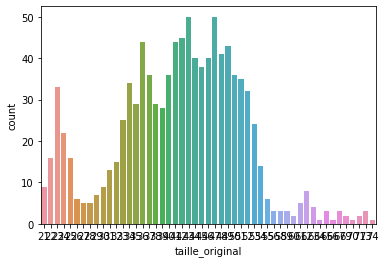

In [8]:
sns.countplot(toplot1, x = 'Category')

D:\Programmes\Anaconda\envs\My-project\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='taille_original', ylabel='count'>

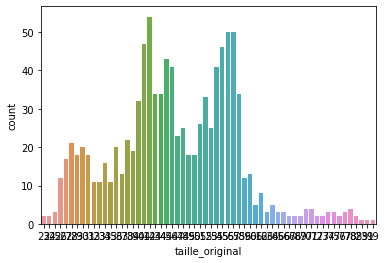

In [9]:
sns.countplot(toplot2, x = 'Category')

D:\Programmes\Anaconda\envs\My-project\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programmes\Anaconda\envs\My-project\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='taille_original', ylabel='Density'>

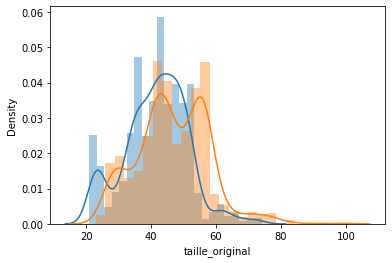

In [10]:
sns.distplot(toplot1)
sns.distplot(toplot2)

D:\Programmes\Anaconda\envs\My-project\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='distance', ylabel='count'>

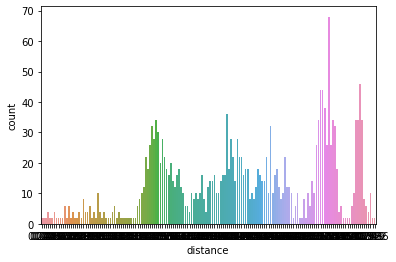

In [11]:
toplot = df.iloc[0:2000, 1026]
sns.countplot(toplot, x = 'Category')

D:\Programmes\Anaconda\envs\My-project\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='distance', ylabel='Density'>

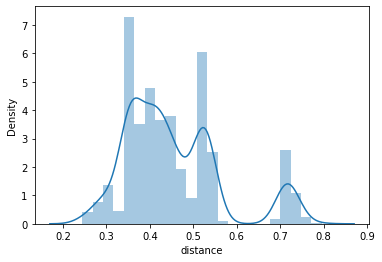

In [12]:
sns.distplot(toplot)